(720, 1280, 3)
[array([[[  0,   0,   0, ...,  26,  26,  26],
        [  0,   0,   0, ...,  26,  26,  26],
        [  0,   0,   0, ...,  26,  26,  26],
        ..., 
        [195, 195, 195, ..., 221, 221, 221],
        [195, 195, 195, ..., 221, 221, 221],
        [195, 195, 195, ..., 221, 221, 221]]]), array([[[  0,   0,   0, ...,  32,  32,  32],
        [  0,   0,   0, ...,  32,  32,  32],
        [  0,   0,   0, ...,  32,  32,  32],
        ..., 
        [209, 209, 209, ..., 217, 217, 217],
        [209, 209, 209, ..., 217, 217, 217],
        [209, 209, 209, ..., 217, 217, 217]]]), array([[[  0,   0,   0, ...,  22,  22,  22],
        [  0,   0,   0, ...,  22,  22,  22],
        [  0,   0,   0, ...,  22,  22,  22],
        ..., 
        [212, 212, 212, ..., 218, 218, 218],
        [212, 212, 212, ..., 218, 218, 218],
        [212, 212, 212, ..., 218, 218, 218]]])]
[array([[[ 1.01295922,  0.96844016,  0.92473659, ...,  1.53738115,
          1.55511311,  1.5744293 ],
        [ 1.00177534

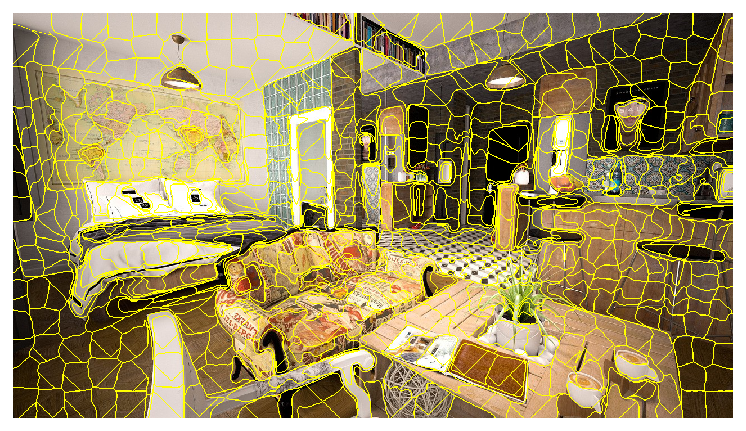

In [15]:
# USAGE
# MR-SLIC_original
from pyspark.context import SparkContext
from skimage.segmentation import mark_boundaries
from skimage import io
import collections as coll
import time
from scipy import ndimage as ndi
from skimage.segmentation import slic
from PIL import Image
from skimage.util import img_as_float
import numpy as np


#import sys
#sys.path.append('/home/gangmin/anaconda3/lib/python3.6/site-packages/skimage')
from skimage.segmentation._slic_master import _slic_cythonM
from skimage.segmentation._slic import _enforce_label_connectivity_cython
from skimage.color import rgb2lab




#sc = SparkContext()

#number of overlap
#number of partition
partition = 3
#resource file name
k=['house_2_1','house_2_2','house_2_3']
#파티션된 이미지 조각의 픽셀 인덱스
listi = [0,180,360]
#목표 세그먼트
OriginSegments = 1500
# 이미지 조각당 세그먼트 수 
numSegments = 250


#원본 이미지 메타데이터(결과 출력용)
images = Image.open('/home/gangmin/MR-SLIC_NEW/resource/house.jpg')

#원본 이미지 크기
(img_w,img_h) = images.size
depth = 1

images = img_as_float(images)

print(images.shape)
#map 함수
def Map(k):
    #time check
    start_time = time.time()
    
    
    #read imagez
    #submit image with job 
    img = Image.open('/home/gangmin/MR-SLIC_NEW/resource/'+ k +'.jpg')
    
    image = img_as_float(img)
    #슬레이브 노드로 작업 분배
    #각 노드에서 이미지 읽고 작업
    segments,distances = slic(image, n_segments = numSegments, sigma = 5)
    #segments(lable(nesre_segments))데이터와 distance 데이터를 둘다 받는다.
    
    
    finish_time = time.time()
    #k 로 1,2,3 숫자 받는다.
    return segments, distances, start_time, finish_time, k[-1]

#times, segments, distances 를 리턴받는다.
stime = time.time()
datas = sc.parallelize(k,partition).map(Map).collect()
ftime = time.time()

#원본 이미지 메타데이터로 dimension 전송
dimension = [depth,img_h,img_w]
dimension = np.ascontiguousarray(dimension)

#segments, distances 리스트 만들기
seglist = []
distlist = []
indlist = []
for i in datas:
    seglist += [i[0][np.newaxis,:]]
    distlist += [i[1]]
    indlist += [int(i[4])]
    
    
print(seglist)
print(distlist)
print(indlist)
    
result = _slic_cythonM(np.ascontiguousarray(distlist),np.ascontiguousarray(seglist),np.ascontiguousarray(indlist),dimension,np.ascontiguousarray(listi))

#label 결속 처리
if 1:
    segment_size = depth * img_h * img_w / OriginSegments
    min_size = int(0.5 * segment_size)
    max_size = int(3 * segment_size)
    labels = _enforce_label_connectivity_cython(result,min_size,max_size)
fftime = time.time()
    
#time check
import pandas as pd
data = pd.DataFrame(columns=['node','time'])
number = 0
node = 1
datat = pd.DataFrame(columns=['node','time'])
pd.options.display.float_format = '{:.6f}'.format
for i in datas:
    datat.loc[number]=['node '+str(node),i[3]-i[2]]
    
    data.loc[number]=['node '+str(node)+' start',i[2]]
    number += 1
    data.loc[number]=['node '+str(node)+' finish',i[3]]
    number += 1
    node+=1

#network time
for i in [0,2,4]:
    print('network_ in_time : '+str(data['time'][i]-stime))
for i in [1,3,5]:
    print('network_ out_time : '+str(ftime-data['time'][i]))
    
    
data = data.sort_values(by=['time'], axis=0)

#print
#slave time
print('slave node time')
print(data)

print(datat)

#reduce time
print('master_time : '+str(fftime-ftime))

#whole time
print('whole_time : '+str(fftime-stime))




import matplotlib.pyplot as plt
#save result
fig = plt.figure("Superpixels -- %d segments" % (numSegments),dpi = 96,figsize = (img_h/96,img_w/96))
ax = fig.add_subplot(1, 1, 1)
print(labels.shape)
'''
#segment 확인
#print(np.unique(labels[0]))
import pickle
## Save pickle
with open("/home/gangmin/image-resource/result.pickle","wb") as fw:
    pickle.dump(labels[0], fw)
'''

ax.imshow(mark_boundaries(images, labels[0]))
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
    
#plt.savefig('/home/gangmin/image-resource/result.png',bbox_inces='tight',pad_inches=0)

plt.axis("off")

# show the plots
plt.show()

